262

269 французские слова

278 другие буквы

321

338

391

396

472 #

481 ;

498 неразрывный пробел

588

809 список в маркдауне

816

834 надпись plot outline description

838

872 &mdash длинное тире

# Задание 9. Кластеризация текстов

Возьмите набор данных Book Genre Prediction с Kaggle.
https://www.kaggle.com/datasets/athu1105/book-genre-prediction

Библиотеки

In [52]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, v_measure_score, normalized_mutual_info_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# wordcloud drawing
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# html tags removing
import re
from bs4 import BeautifulSoup

# nltk stopwords removing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# nltk stemming
from nltk.stem import PorterStemmer

# lemmatizing
nltk.download('wordnet')
nltk.download('omw-1.4')
from textblob import Word

# for punctuation removing
import string

# warnings off
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Константы

In [53]:
WORDCLOUD_STOPWORDS = set(STOPWORDS)
NLTK_STOPWORDS = stopwords.words('english')

Данные

In [54]:
#files.upload()
text_data = pd.read_csv('data.csv').set_index('index')
text_data

title    genre  \
index                                               
0                      Drowned Wednesday  fantasy   
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  
index                                                     
0       Drowned Wednesday is the first Trustee among ...  
1       As the book opens, Jason awakens on a school ...  
2       Cugel is easily persuaded by the merchant Fia...  
3       The book opens with Herald-Mage Vanyel return...  
4       Taran and Gurgi have returned to Caer Dallben...  
...                                                  ...  
4652   Atticus O’Sullivan, last of the Druids, lives ...  
4653   Charlie Bucket's wonderful adventure begins wh...  
4654   "I live for the dream that my children will be...  
4655   Rose loves Dimitri, Dimitri might love Tasha, ...  
4656   The Prince of no value\nBrishen Khaskem, princ...  

[4657 rows x 3 columns]

## 0) Изучите и опишите его: какие данные представлены, есть ли пропуски, равномерно ли распределены книги по жанрам, одинаковая ли длина кратких содержаний и т.п.

### Типы данных и пропуски.

In [55]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4657 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4657 non-null   object
 1   genre    4657 non-null   object
 2   summary  4657 non-null   object
dtypes: object(3)
memory usage: 145.5+ KB


Три колонки типа object, пропусков нет.

### Распределение по жанрам.

In [56]:
genres_text_data = text_data.groupby('genre').aggregate('count'). \
drop(columns=['summary']).rename(columns={'title': 'count'}).reset_index()
display(genres_text_data)

genre  count
0       crime    500
1     fantasy    876
2     history    600
3      horror    600
4  psychology    100
5     romance    111
6     science    647
7      sports    100
8    thriller   1023
9      travel    100

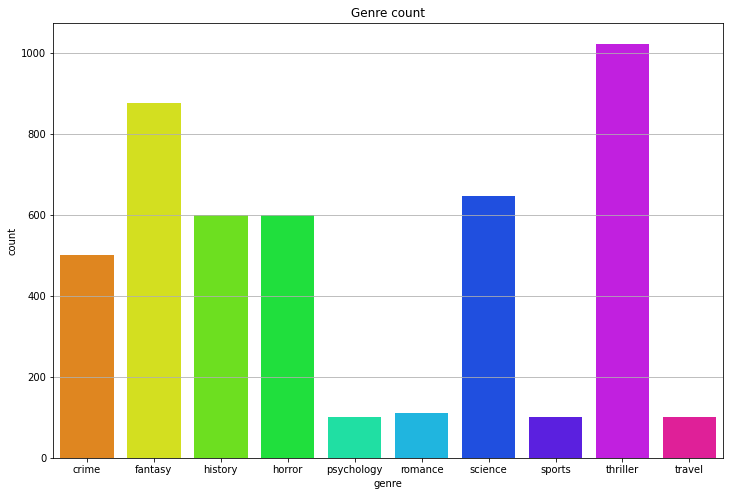

In [57]:
_, ax_ = plt.subplots(figsize=(12, 8))
plt.grid(True)
plt.title('Genre count')
sns.barplot(data=genres_text_data, x='genre', y='count', palette='hsv');

Распределение по жанрам неравномерное.

### Длина кратких содержаний.

In [58]:
text_data['summary_length'] = text_data.summary.apply(lambda x: len(x))
display(text_data)

title    genre  \
index                                               
0                      Drowned Wednesday  fantasy   
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  summary_length  
index                                                                     
0       Drowned Wednesday is the first Trustee among ...            4704  
1       As the book opens, Jason awakens on a school ...            3127  
2       Cugel is easily persuaded by the merchant Fia...            1953  
3       The book opens with Herald-Mage Vanyel return...            4598  
4       Taran and Gurgi have returned to Caer Dallben...            6743  
...                                                  ...             ...  
4652   Atticus O’Sullivan, last of the Druids, lives ...             890  
4653   Charlie Bucket's wonderful adventure begins wh...             249  
4654   "I live for the dream that my children will be...            1371  
4655   Rose loves Dimitri, Dimitri might love Tasha, ...             983  
4656   The Prince of no value\nBrishen Khaskem, princ...            1094  

[4657 rows x 4 columns]

In [59]:
summary_length_statistics = text_data.summary_length.aggregate(['count', 'min', 'max', 'mean', np.median])
display(summary_length_statistics)

count      4657.000000
min          11.000000
max       31263.000000
mean       2106.322311
median     1141.000000
Name: summary_length, dtype: float64

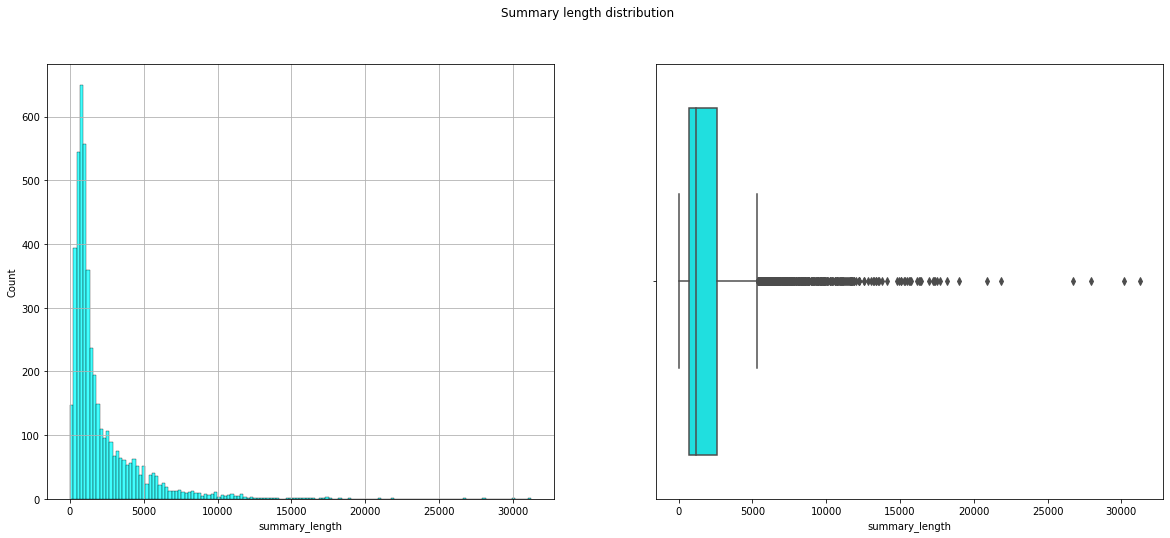

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Summary length distribution')

axes[0].grid(True)
sns.histplot(ax=axes[0], x=text_data.summary_length, color='cyan');
sns.boxplot(ax=axes[1], x=text_data.summary_length, color='cyan');

По жанрам.

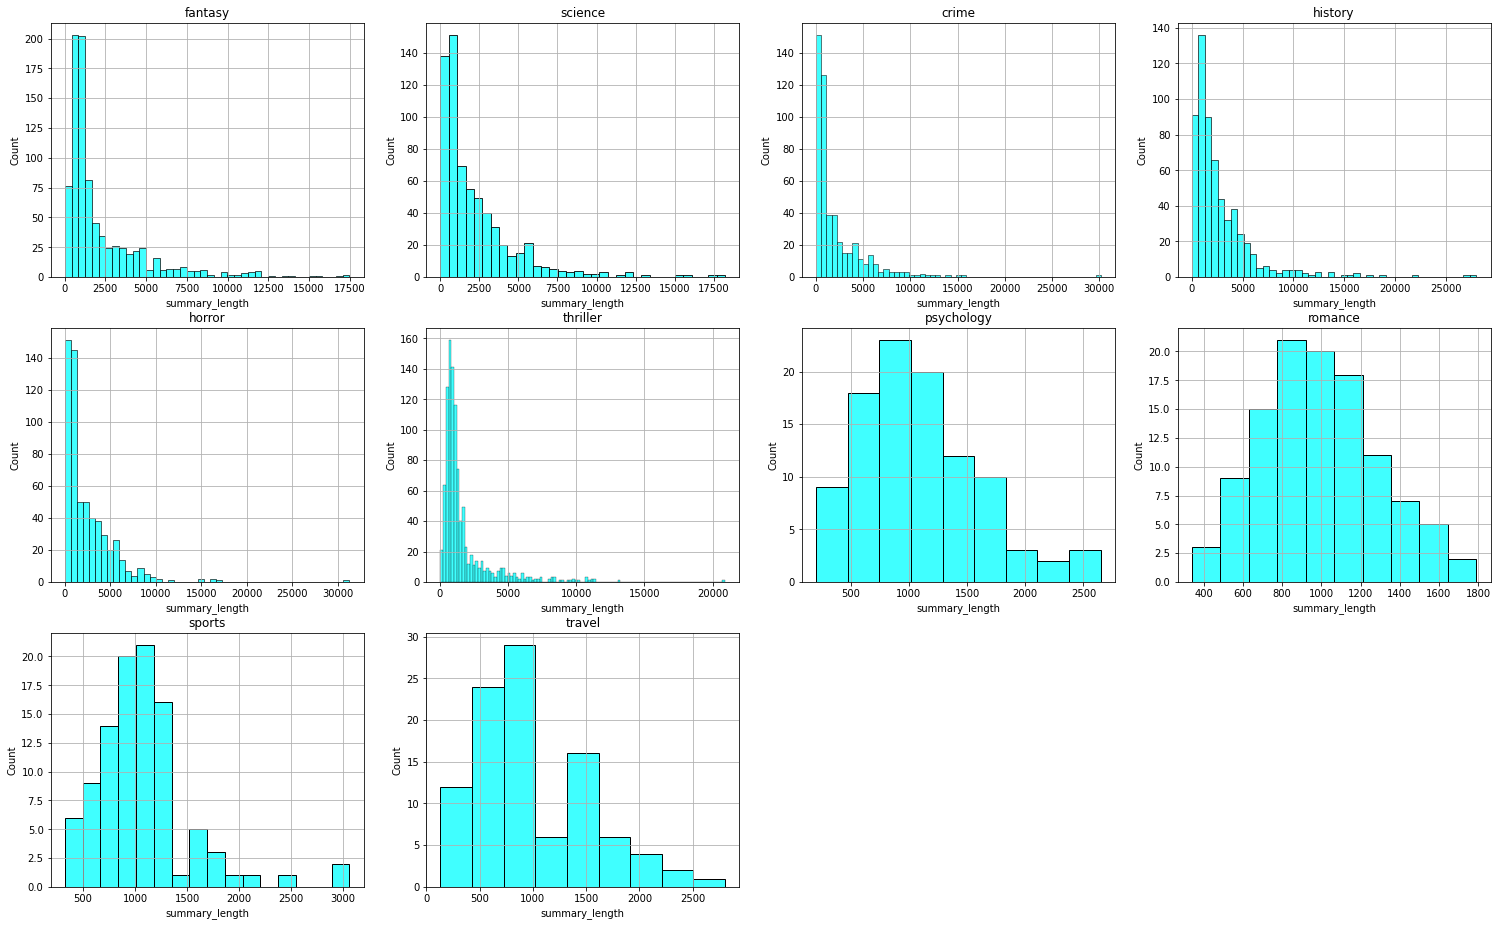

In [61]:
fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

plot_amount = [i for i in range(len(text_data.genre.unique()))]

for i, current_genre in zip(plot_amount, text_data.genre.unique()):
  current_df = text_data[text_data.genre == current_genre]
  ax_ = fig.add_subplot(3, 4, i + 1) # , xticks=[], yticks=[])
  ax_.grid(True)
  sns.histplot(ax=ax_, x=current_df.summary_length, color='cyan');
  ax_.set_title(current_genre);

Слишком короткие рецензии, состоящие из служебных слов, чтобы удалить на этапе предобработки.

In [62]:
too_short_text_data = text_data[text_data.summary_length <= 100]
too_short_text_data

title     genre  \
index                                                                
12                                          Master Alvin   fantasy   
55                                      The Lady Decides   fantasy   
155                                       Death's Deputy   fantasy   
262                                 Deathstalker Destiny   fantasy   
319                                      City of Sorcery   fantasy   
338                                 The Caverns of Kalte   fantasy   
472                           Mistborn: The Alloy of Law   fantasy   
529                                      Drunkard's Walk   science   
552                                           G.O.G. 666   science   
588                                Missing Men of Saturn   science   
692                                   Dreadful Sanctuary   science   
710                                  Minions of the Moon   science   
713                                     Archform: Beauty   science   
834                             Stadium Beyond the Stars   science   
838                                    Street of Shadows   science   
859                                          Bullet Time   science   
877                                       Murder Madness   science   
907                                 The Abyss of Wonders   science   
942    Babylon 5: Legions of Fire - Armies of Light a...   science   
960                                  The Planet of Youth   science   
1009                                Yōgisha X no Kenshin     crime   
1049                                The Hidden Assassins     crime   
1334                                     The Body Lovers     crime   
1574             Guardians of Ga'Hoole Book 4: The Siege   history   
1772                  Grania: She-King of the Irish Seas   history   
2015                                      The Black Wolf    horror   
2142                                         Winter Moon    horror   
2273                            The Dark Cry of the Moon    horror   
2312                                          Yellow Fog    horror   
2410                                The Eyes of Darkness    horror   
2431                           The Horror from the Hills    horror   
2435                        The Soft Whisper of the Dead    horror   
2438                         The Long Night of the Grave    horror   
2485                                          Created By    horror   
2633                                     Nothing to Lose  thriller   
2933                                             Jackals  thriller   
2936                                          Conviction  thriller   
2967                                      The Apprentice  thriller   

                                                 summary  summary_length  
index                                                                     
12      This book has yet to be published. At this ti...              87  
55      The novel concerns a man with a dream and an ...              78  
155     The novel concerns a man who is unnaturally a...              60  
262                                    - --&#62; &#60;!-              17  
319     The novel concerns the quest of Magdalen Lorn...              88  
338                                           ==Receptio              11  
472     Tor has given a short synopsis of the novel, ...              68  
529     The novel tells the story of a professor who ...              73  
552     The novel concerns Russian genetics experimen...              99  
588                       ~Plot outline description~ -->              31  
692     The novel concerns an international conspirac...              96  
710     The novel is a space opera about a contempora...              83  
713       Archform: Beauty is set in 24th century Earth.              47  
834                          - ~Plot outline description              27  
838     The story features characters from the Med

In [63]:
too_short_text_data = text_data[text_data.summary_length <= 40]
too_short_text_data

title    genre  \
index                                                     
262                       Deathstalker Destiny  fantasy   
338                       The Caverns of Kalte  fantasy   
588                      Missing Men of Saturn  science   
834                   Stadium Beyond the Stars  science   
1049                      The Hidden Assassins    crime   
1574   Guardians of Ga'Hoole Book 4: The Siege  history   
1772        Grania: She-King of the Irish Seas  history   
2410                      The Eyes of Darkness   horror   
2485                                Created By   horror   

                                       summary  summary_length  
index                                                           
262                          - --&#62; &#60;!-              17  
338                                 ==Receptio              11  
588             ~Plot outline description~ -->              31  
834                - ~Plot outline description              27  
1049    The novel tackles themes of terrorism.              39  
1574                                ==Receptio              11  
1772       ~Plot outline description~ --> <!--              36  
2410                               ==Character              12  
2485                 ~Plot outline description              26

In [64]:
too_short_text_data = text_data[text_data.summary_length <= 37]
too_short_text_data

title    genre  \
index                                                     
262                       Deathstalker Destiny  fantasy   
338                       The Caverns of Kalte  fantasy   
588                      Missing Men of Saturn  science   
834                   Stadium Beyond the Stars  science   
1574   Guardians of Ga'Hoole Book 4: The Siege  history   
1772        Grania: She-King of the Irish Seas  history   
2410                      The Eyes of Darkness   horror   
2485                                Created By   horror   

                                    summary  summary_length  
index                                                        
262                       - --&#62; &#60;!-              17  
338                              ==Receptio              11  
588          ~Plot outline description~ -->              31  
834             - ~Plot outline description              27  
1574                             ==Receptio              11  
1772    ~Plot outline description~ --> <!--              36  
2410                            ==Character              12  
2485              ~Plot outline description              26

В рамки меньше либо равно 40 ещё попадают осмысленные рецензии, а вот 37 показывает все несмысловые. Создадим список индексов для удаления.

In [65]:
list_of_indexes_to_delete_non_descriptive_summaries = list(too_short_text_data.index.unique())
list_of_indexes_to_delete_non_descriptive_summaries

[262, 338, 588, 834, 1574, 1772, 2410, 2485]

### Тексты без стоп-слов.

Колонка title

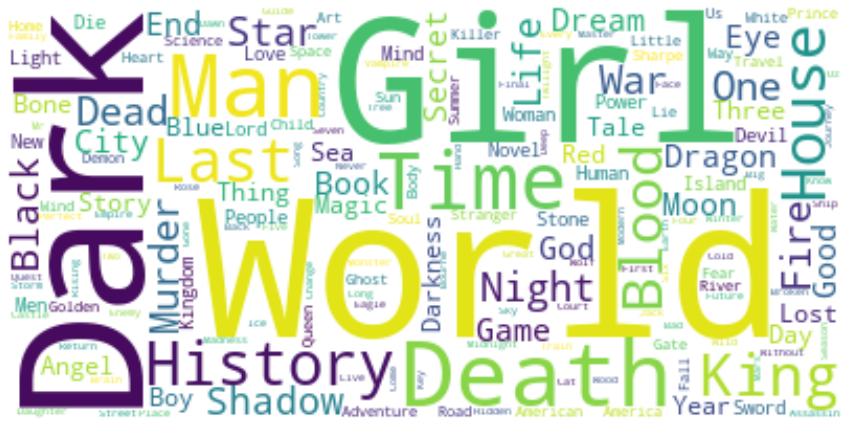

In [66]:
text = " ".join(i for i in text_data.title)
wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

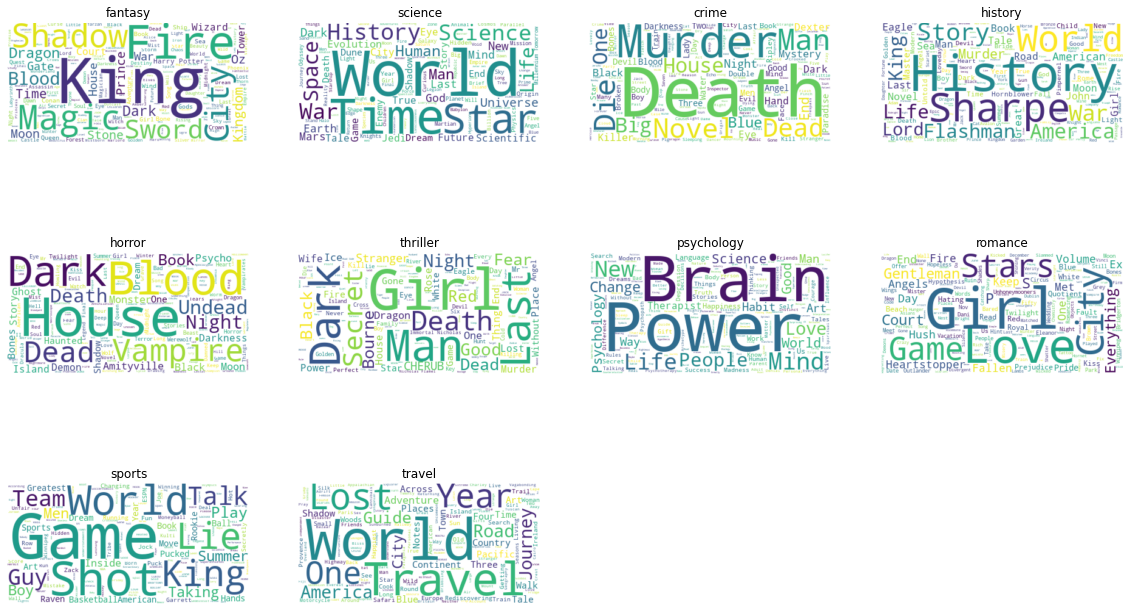

In [67]:
fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust()#(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

plot_amount = [i for i in range(len(text_data.genre.unique()))]

for i, current_genre in zip(plot_amount, text_data.genre.unique()):
  current_df = text_data[text_data.genre == current_genre]
  ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
  current_text = " ".join(i for i in current_df.title)
  wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(current_text)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(current_genre);

Колонка summary

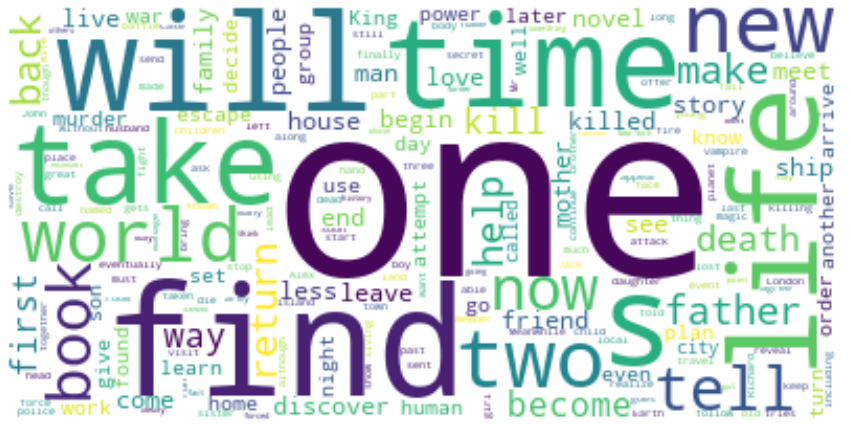

In [68]:
text = " ".join(i for i in text_data.summary)
wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(text)
# wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

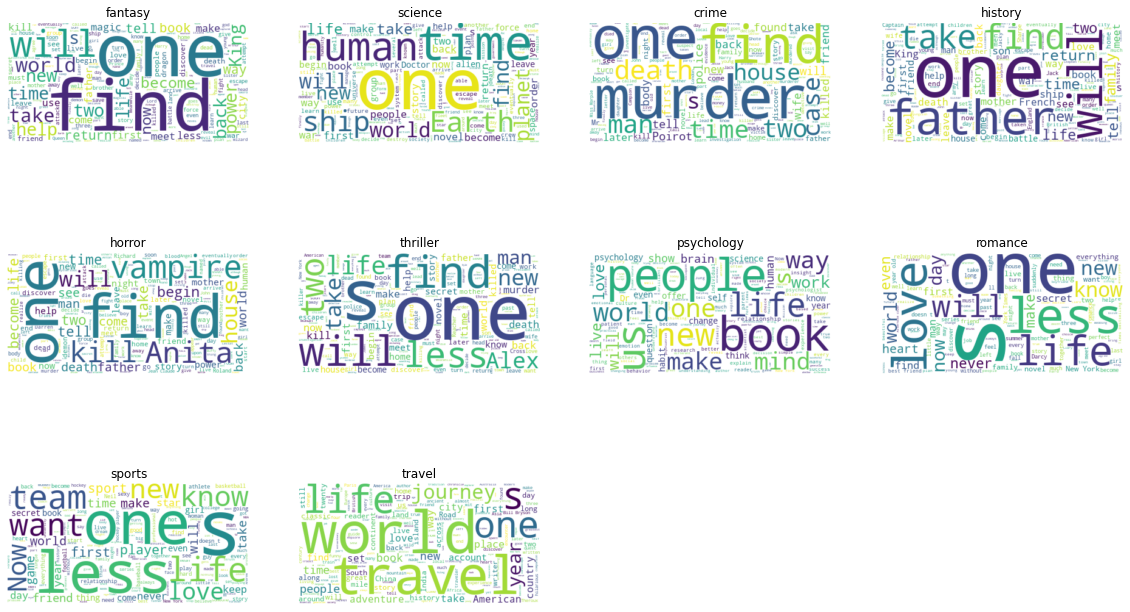

In [69]:
fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust()#(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

plot_amount = [i for i in range(len(text_data.genre.unique()))]

for i, current_genre in zip(plot_amount, text_data.genre.unique()):
  current_df = text_data[text_data.genre == current_genre]
  ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
  current_text = " ".join(i for i in current_df.summary)
  wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(current_text)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(current_genre);


## 1) Проведите предобработку данных. Подготовьте данные для кластеризации (используем только колонку "summary") по принципу "мешка слов" двумя способами:

Извлечение текстовых признаков (scikit-learn)
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

### Предобработка

Удаление не несущих смысла описаний

In [70]:
text_data = text_data.drop(list_of_indexes_to_delete_non_descriptive_summaries)
text_data

title    genre  \
index                                               
0                      Drowned Wednesday  fantasy   
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  summary_length  
index                                                                     
0       Drowned Wednesday is the first Trustee among ...            4704  
1       As the book opens, Jason awakens on a school ...            3127  
2       Cugel is easily persuaded by the merchant Fia...            1953  
3       The book opens with Herald-Mage Vanyel return...            4598  
4       Taran and Gurgi have returned to Caer Dallben...            6743  
...                                                  ...             ...  
4652   Atticus O’Sullivan, last of the Druids, lives ...             890  
4653   Charlie Bucket's wonderful adventure begins wh...             249  
4654   "I live for the dream that my children will be...            1371  
4655   Rose loves Dimitri, Dimitri might love Tasha, ...             983  
4656   The Prince of no value\nBrishen Khaskem, princ...            1094  

[4649 rows x 4 columns]

Удаление текстов, использующих не только английский язык

In [71]:
list_of_other_characters = []

In [72]:
def is_English_only(str_in):
  for symbol in str_in:
    if symbol.isalpha() and symbol not in string.ascii_letters:
      list_of_other_characters.append(symbol)
      return False
  return True

In [73]:
text_data['is_English_only'] = text_data['summary'].apply(lambda x: is_English_only(x))
lang_text_data = text_data.groupby('is_English_only').aggregate('count')
lang_text_data

title  genre  summary  summary_length
is_English_only                                       
False              413    413      413             413
True              4236   4236     4236            4236

In [74]:
for item in set(list_of_other_characters):
  print(item, end=" ")

Å Ö К ś ć Ź ý É ū ê ر æ 高 ë ò ẽ ب Л З ń ã Α Λ ł ì Õ À á ʼ リ ù ā ç ü ا č ع ö ה î آ С О Á Ś ä ய à د Æ ñ ň ţ τ پ দ ï ó Т ش Ţ ú â Ü ż œ å í ŵ è û é ō พ ô ø 

In [75]:
text_data = text_data[text_data.is_English_only]
text_data

title    genre  \
index                                               
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
5                         Thendara House  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  summary_length  \
index                                                                      
1       As the book opens, Jason awakens on a school ...            3127   
2       Cugel is easily persuaded by the merchant Fia...            1953   
3       The book opens with Herald-Mage Vanyel return...            4598   
4       Taran and Gurgi have returned to Caer Dallben...            6743   
5       The novel concerns the dwelling of the Darkov...             214   
...                                                  ...             ...   
4652   Atticus O’Sullivan, last of the Druids, lives ...             890   
4653   Charlie Bucket's wonderful adventure begins wh...             249   
4654   "I live for the dream that my children will be...            1371   
4655   Rose loves Dimitri, Dimitri might love Tasha, ...             983   
4656   The Prince of no value\nBrishen Khaskem, princ...            1094   

       is_English_only  
index                   
1                 True  
2                 True  
3                 True  
4                 True  
5                 True  
...                ...  
4652              True  
4653              True  
4654              True  
4655              True  
4656              True  

[4236 rows x 5 columns]

Вспомогательная функция для очистки строки

In [76]:
def string_processing(str_in):
  # removing html tags
  soup = BeautifulSoup(str_in, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  str_res = soup.get_text()

  # replacing \n etc.
  str_res = re.sub(r'[\r|\n|\r\n]+', '\n', str_res)
  
  # converting to lower case
  str_res = str_res.lower()

  # replacing n't
  # str_res = re.sub(r'can\'t', 'can not', str_res)
  # str_res = re.sub(r'n\'t', ' not', str_res)

  # removing 's, 're, 'd etc.
  str_res = re.sub(r'\'\w{, 3}', '', str_res)

  # removing stopwords
  str_res = " ".join(x for x in str_res.split() if x not in NLTK_STOPWORDS)

  # removing numbers
  str_res = ''.join([i for i in str_res if not i.isdigit()])

  # removing punctuation
  # str_res = str_res.replace(r'[^\w\s]', '')
  str_res = ''.join([i for i in str_res if not i in string.punctuation])

  # stemming
  st = PorterStemmer()
  str_res = " ".join([st.stem(word) for word in str_res.split()])

  # lemmatizing
  # str_res = " ".join([Word(word).lemmatize() for word in str_res.split()])

  # removing extra words
  extra_words_list = ["one"]
  str_res = " ".join(x for x in str_res.split() if x not in extra_words_list)

  return str_res

In [77]:
text_data['processed_summary'] = text_data['summary'].apply(lambda x: string_processing(x))
text_data

title    genre  \
index                                               
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
5                         Thendara House  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  summary_length  \
index                                                                      
1       As the book opens, Jason awakens on a school ...            3127   
2       Cugel is easily persuaded by the merchant Fia...            1953   
3       The book opens with Herald-Mage Vanyel return...            4598   
4       Taran and Gurgi have returned to Caer Dallben...            6743   
5       The novel concerns the dwelling of the Darkov...             214   
...                                                  ...             ...   
4652   Atticus O’Sullivan, last of the Druids, lives ...             890   
4653   Charlie Bucket's wonderful adventure begins wh...             249   
4654   "I live for the dream that my children will be...            1371   
4655   Rose loves Dimitri, Dimitri might love Tasha, ...             983   
4656   The Prince of no value\nBrishen Khaskem, princ...            1094   

       is_English_only                                  processed_summary  
index                                                                      
1                 True  book open jason awaken school bu unabl rememb ...  
2                 True  cugel easili persuad merchant fianosth attempt...  
3                 True  book open heraldmag vanyel return countri vald...  
4                 True  taran gurgi return caer dallben follow event t...  
5                 True  novel concern dwell darkovan order renunci als...  
...                ...                                                ...  
4652              True  atticu o’sullivan last druid live peac arizona...  
4653              True  charli bucket wonder adventur begin find mr wi...  
4654              True  i live dream children born free say that like ...  
4655              True  rose love dimitri dimitri might love tasha mas...  
4656              True  princ valu brishen khaskem princ kai live cont...  

[4236 rows x 6 columns]

Облако слов для обработанных текстов

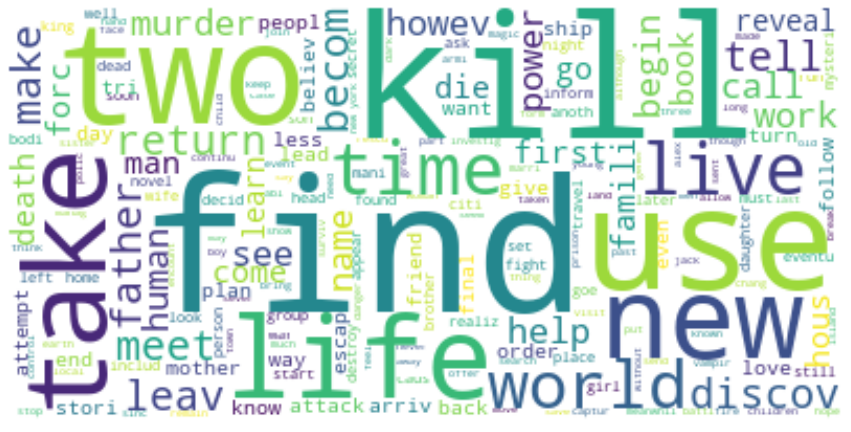

In [78]:
text = " ".join(i for i in text_data.processed_summary)
wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

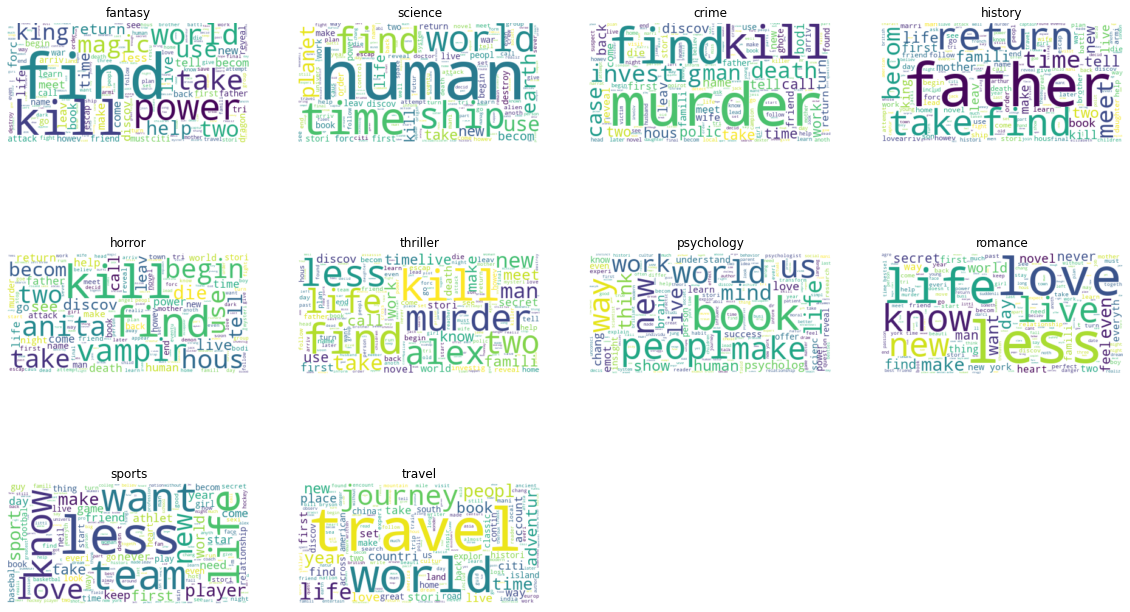

In [79]:
fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust()#(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

plot_amount = [i for i in range(len(text_data.genre.unique()))]

for i, current_genre in zip(plot_amount, text_data.genre.unique()):
  current_df = text_data[text_data.genre == current_genre]
  ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
  current_text = " ".join(i for i in current_df.processed_summary)
  wordcloud = WordCloud(stopwords=WORDCLOUD_STOPWORDS, background_color="white").generate(current_text)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(current_genre);

Метки жанров (чтобы было удобно визуализировать)

In [80]:
enc = OrdinalEncoder()
encoded_genres = enc.fit_transform(text_data)[:, 1]
encoded_genres

array([1., 1., 1., ..., 1., 1., 1.])

### а) подсчётом вхождений слов (CountVectorizer)


In [81]:
vectorizer = CountVectorizer()
count_vec = vectorizer.fit_transform(text_data.processed_summary).toarray()
display(count_vec)
display(count_vec.shape)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(4236, 39502)

### б) с использованием меры tf – idf (TfidfVectorizer)

In [82]:
transformer = TfidfVectorizer(smooth_idf=False)
tfidf_vec = transformer.fit_transform(text_data.processed_summary).toarray()
display(tfidf_vec)
display(tfidf_vec.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(4236, 39502)

## 2) Кластеризуйте оба представления методом k-средних на 10 кластеров (по числу исходных жанров), уменьшите размерность с помощью метода главных компонент (PCA) и визуализируйте разбиение. Оцените результаты с помощью силуэтной метрики (silhouette_score) и визуально. Пересекается ли полученное разбиение с жанрами? Можно ли найти другое объяснение полученным кластерам?

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

### Уменьшение размерности и кластеризация.

In [83]:
pca = PCA(n_components=2)
pca_count_vec = pca.fit_transform(count_vec)

kmeans_labels_count_vec = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(pca_count_vec)
kmeans_labels_count_vec

array([4, 9, 2, ..., 9, 9, 0], dtype=int32)

In [84]:
pca = PCA(n_components=2)
pca_tfidf_vec = pca.fit_transform(tfidf_vec)

kmeans_labels_tfidf_vec = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(pca_tfidf_vec)
kmeans_labels_tfidf_vec

array([2, 8, 2, ..., 4, 6, 4], dtype=int32)

### Визуализация.

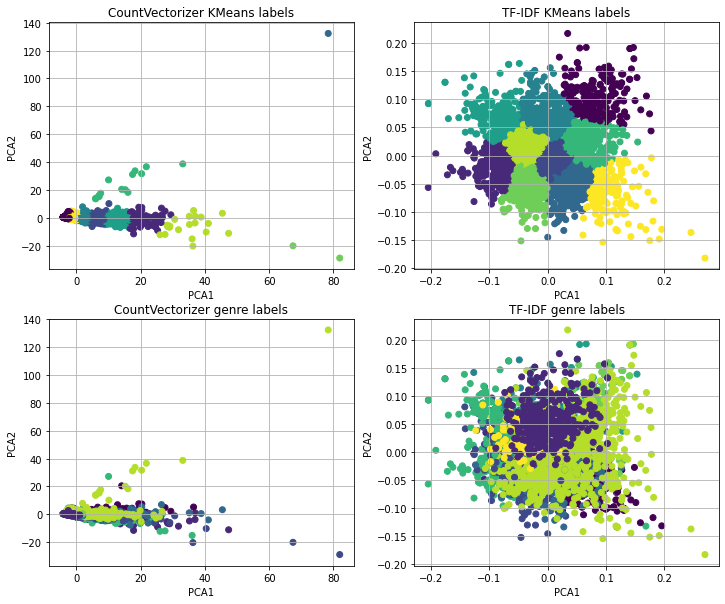

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax1.scatter(pca_count_vec[:, 0], pca_count_vec[:, 1], c=kmeans_labels_count_vec) 
ax1.grid(True)
ax1.set_title("CountVectorizer KMeans labels")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2");

ax2.scatter(pca_tfidf_vec[:, 0], pca_tfidf_vec[:, 1], c=kmeans_labels_tfidf_vec) 
ax2.grid(True)
ax2.set_title("TF-IDF KMeans labels")
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2");

ax3.scatter(pca_count_vec[:, 0], pca_count_vec[:, 1], c=encoded_genres) 
ax3.grid(True)
ax3.set_title("CountVectorizer genre labels")
ax3.set_xlabel("PCA1")
ax3.set_ylabel("PCA2");

ax4.scatter(pca_tfidf_vec[:, 0], pca_tfidf_vec[:, 1], c=encoded_genres) 
ax4.grid(True)
ax4.set_title("TF-IDF genre labels")
ax4.set_xlabel("PCA1")
ax4.set_ylabel("PCA2");

### Подсчет метрики силуэт

In [86]:
silhouette_score_count_vec_pca = silhouette_score(pca_count_vec, kmeans_labels_count_vec)
silhouette_score_count_vec_pca

0.4543122747325703

In [87]:
silhouette_score_tfidf_vec_pca = silhouette_score(pca_tfidf_vec, kmeans_labels_tfidf_vec)
silhouette_score_tfidf_vec_pca

0.3162737536928849

In [88]:
kmeans_score_df = pd.DataFrame({'Silhouette': [silhouette_score_count_vec_pca, silhouette_score_tfidf_vec_pca]},
                               index=['CountVec', 'TF-IDF'])
kmeans_score_df

Silhouette
CountVec    0.454312
TF-IDF      0.316274

Силуэт считает, что CountVec лучше

### Похожесть на жанры

CountVec

In [89]:
v_measure_score(kmeans_labels_count_vec, encoded_genres)

0.030462283001173367

In [90]:
normalized_mutual_info_score(kmeans_labels_count_vec, encoded_genres)

0.03046228300117337

TF-IDF

In [91]:
v_measure_score(kmeans_labels_tfidf_vec, encoded_genres)

0.19132501555956047

In [92]:
normalized_mutual_info_score(kmeans_labels_tfidf_vec, encoded_genres)

0.19132501555956047

TF-IDF чуть больше похож, но все равно не очень

### По названиям

Может быть, по названиям лучше получится? Попробуем TF-IDF + KMeans

In [93]:
text_data['processed_title'] = text_data['title'].apply(lambda x: string_processing(x))
text_data

title    genre  \
index                                               
1                          The Lost Hero  fantasy   
2              The Eyes of the Overworld  fantasy   
3                        Magic's Promise  fantasy   
4                         Taran Wanderer  fantasy   
5                         Thendara House  fantasy   
...                                  ...      ...   
4652                             Hounded  fantasy   
4653   Charlie and the Chocolate Factory  fantasy   
4654                          Red Rising  fantasy   
4655                           Frostbite  fantasy   
4656                            Radiance  fantasy   

                                                 summary  summary_length  \
index                                                                      
1       As the book opens, Jason awakens on a school ...            3127   
2       Cugel is easily persuaded by the merchant Fia...            1953   
3       The book opens with Herald-Mage Vanyel return...            4598   
4       Taran and Gurgi have returned to Caer Dallben...            6743   
5       The novel concerns the dwelling of the Darkov...             214   
...                                                  ...             ...   
4652   Atticus O’Sullivan, last of the Druids, lives ...             890   
4653   Charlie Bucket's wonderful adventure begins wh...             249   
4654   "I live for the dream that my children will be...            1371   
4655   Rose loves Dimitri, Dimitri might love Tasha, ...             983   
4656   The Prince of no value\nBrishen Khaskem, princ...            1094   

       is_English_only                                  processed_summary  \
index                                                                       
1                 True  book open jason awaken school bu unabl rememb ...   
2                 True  cugel easili persuad merchant fianosth attempt...   
3                 True  book open heraldmag vanyel return countri vald...   
4                 True  taran gurgi return caer dallben follow event t...   
5                 True  novel concern dwell darkovan order renunci als...   
...                ...                                                ...   
4652              True  atticu o’sullivan last druid live peac arizona...   
4653              True  charli bucket wonder adventur begin find mr wi...   
4654              True  i live dream children born free say that like ...   
4655              True  rose love dimitri dimitri might love tasha mas...   
4656              True  princ valu brishen khaskem princ kai live cont...   

             processed_title  
index                         
1                  lost hero  
2              eye overworld  
3               magic promis  
4               taran wander  
5              thendara hous  
...                      ...  
4652                   hound  
4653   charli chocol factori  
4654                red rise  
4655                frostbit  
4656                 radianc  

[4236 rows x 7 columns]

In [94]:
transformer = TfidfVectorizer(smooth_idf=False)
tfidf_vec_title = transformer.fit_transform(text_data.processed_title).toarray()
display(tfidf_vec_title)
display(tfidf_vec_title.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(4236, 3638)

In [95]:
pca = PCA(n_components=2)
pca_tfidf_vec_title = pca.fit_transform(tfidf_vec_title)

kmeans_labels_tfidf_vec_title = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(pca_tfidf_vec_title)
kmeans_labels_tfidf_vec_title

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

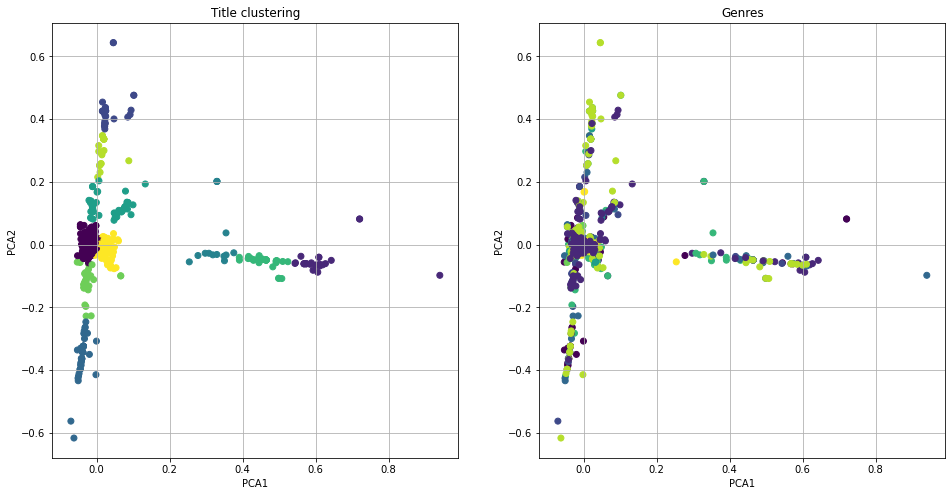

In [96]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.scatter(pca_tfidf_vec_title[:, 0], pca_tfidf_vec_title[:, 1], c=kmeans_labels_tfidf_vec_title) 
ax1.grid(True)
ax1.set_title("Title clustering")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2");

ax2.scatter(pca_tfidf_vec_title[:, 0], pca_tfidf_vec_title[:, 1], c=encoded_genres) 
ax2.grid(True)
ax2.set_title("Genres")
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2");

In [97]:
v_measure_score(kmeans_labels_tfidf_vec_title, encoded_genres)

0.02247480902684282

Не получилось

## 3) Возьмите две другие метрики оценки качества кластеризации, для каждой подберите способ кластеризации и параметры, дающие наилучшее значение. Используя подобранные методы и параметры, проведите кластеризацию, визуализируйте результаты и оцените их в том числе с точки зрения интерпретируемости.

https://scikit-learn.org/stable/modules/classes.html#clustering-metrics

Теория: метрики кластеризации

https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.9A.D0.BE.D0.BC.D0.BF.D0.B0.D0.BA.D1.82.D0.BD.D0.BE.D1.81.D1.82.D1.8C_.D0.BA.D0.BB.D0.B0.D1.81.D1.82.D0.B5.D1.80.D0.BE.D0.B2_.28.D0.B0.D0.BD.D0.B3.D0.BB._Cluster_Cohesion.29

### Вспомогательная функция для формирования датафрейма с метриками

In [98]:
def make_add_scores_df(metric):
  # KMeans
  kmeans_count_vec_score = metric(pca_count_vec, kmeans_labels_count_vec)
  kmeans_tfidf_vec_score = metric(pca_tfidf_vec, kmeans_labels_tfidf_vec)
  
  # AgglomerativeClustering
  hierarchical_labels_count_vec = AgglomerativeClustering(n_clusters=10).fit_predict(pca_count_vec)
  hierarchical_labels_tfidf_vec = AgglomerativeClustering(n_clusters=10).fit_predict(pca_tfidf_vec)

  hierarchical_count_vec_score = metric(pca_count_vec, hierarchical_labels_count_vec)
  hierarchical_tfidf_vec_score = metric(pca_tfidf_vec, hierarchical_labels_tfidf_vec)

  # DBSCAN
  dbscan_labels_count_vec = DBSCAN(eps=0.05).fit_predict(pca_count_vec)
  dbscan_labels_tfidf_vec = DBSCAN(eps=0.05).fit_predict(pca_tfidf_vec)

  dbscan_count_vec_score = metric(pca_count_vec, dbscan_labels_count_vec)
  dbscan_tfidf_vec_score = metric(pca_tfidf_vec, dbscan_labels_tfidf_vec)

  # making dataframe
  metric_df = pd.DataFrame({'KMeans': [kmeans_count_vec_score, kmeans_tfidf_vec_score],
                            'AgglomerativeClustering': [hierarchical_count_vec_score, hierarchical_tfidf_vec_score],
                            'DBSCAN': [dbscan_count_vec_score, dbscan_tfidf_vec_score]},
                               index=['CountVec', 'TF-IDF'])

  return metric_df

### Индекс Calinski–Harabasz

Компактность основана на расстоянии от точек кластера до их центроидов, а разделимость - на расстоянии от центроид кластеров до глобального центроида. Должен возрастать.

In [99]:
calinski_harabasz_score_df = make_add_scores_df(calinski_harabasz_score)
calinski_harabasz_score_df

KMeans  AgglomerativeClustering     DBSCAN
CountVec  6446.514779              5998.109775  31.779374
TF-IDF    2519.789391              2007.033120  32.136835

### Индекс Дэвиcа-Болдуина

Индекс Дэвиcа-Болдуина должен минимизироваться для роста кластеризации.

In [100]:
davies_bouldin_score_df = make_add_scores_df(davies_bouldin_score)
davies_bouldin_score_df

KMeans  AgglomerativeClustering    DBSCAN
CountVec  0.681728                 0.682090  1.159578
TF-IDF    0.854166                 0.966973  0.300540

### Визуализация лучших разбиений

In [101]:
# by calinski_harabasz_score
calinski_harabasz_best_labels = kmeans_labels_count_vec.copy()

# by davies_bouldin_score
davies_bouldin_best_labels = DBSCAN(eps=0.05).fit_predict(pca_tfidf_vec)

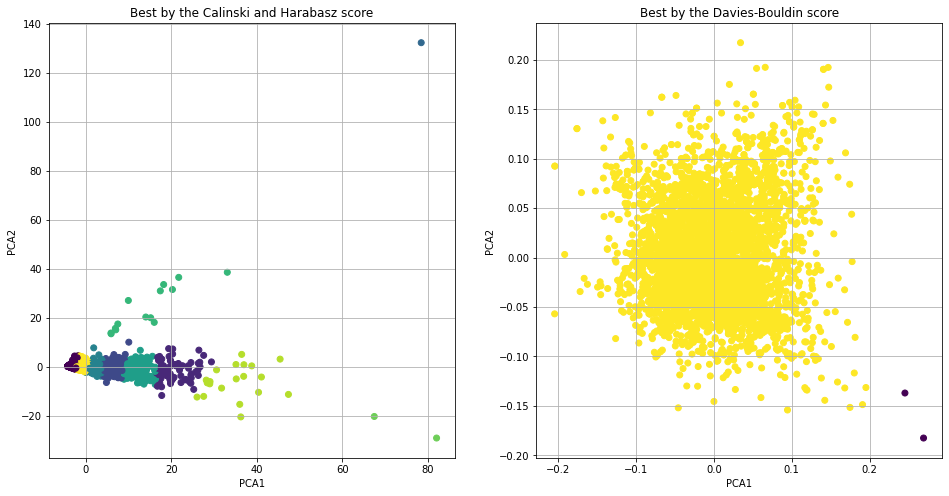

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.scatter(pca_count_vec[:, 0], pca_count_vec[:, 1], c=calinski_harabasz_best_labels) 
ax1.grid(True)
ax1.set_title("Best by the Calinski and Harabasz score")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2");

ax2.scatter(pca_tfidf_vec[:, 0], pca_tfidf_vec[:, 1], c=davies_bouldin_best_labels) 
ax2.grid(True)
ax2.set_title("Best by the Davies-Bouldin score")
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2");